In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
from scipy.stats import norm
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 5)

#### Q1.1
- No it is Not reasonable to use just the indivual Sharpe ratios or crypto v/s other assets. Since an optimal portfolio depends on the correlation and covariances across the different assets rather than individual asset volatilities or variances only. It would be much more beneficial to compare the correlations of Crypto across the existing asset classes to make this decision.

#### Q1.2
- True, as the sigma or covariance matrix inversion is very fragile and leads to huge swings in the asset allocation (Betas) when the asset mean returns change by even a small amount.

#### Q1.3
- We found that the historical VaR has a frequency (hit ratio) of around 3% for a 5% VaR. Thus our historical model overestimates VaR as the actual frequency is lower than our the 5% the we expect. The rolling window empirical VaR performed much better with a frequency of around 4.96% for a 5% VaR. Thus our rolling window empirical model is a better model for VaR estimation.

#### Q1.4
What approach does Harvard take to getting more realistic weights? What is a problem with this approach?

- Harvard uses a portfolio of diversified assets to create a portfolio using different constraints
- First constraint was to use portfolio weights between 0 and 1, and the second constraint was to limit cash from -0.5 to 1.
- Using MV optimization on such a portfolio is very sensitive to the means and covariances due to the full covariance matrix.
- We observe computational difficulty as well as it could lead to poor Out of Sample results.

#### Q1.5
What aspect of tools such as Ridge regression and LASSO regression are useful in mean- variance optimization? That is, what problem in the classic MV solution are they addressing?

- Ridge regression and LASSO regression are useful in mean-variance optimization as they help in reducing the number of predictors in a regression model. These are regularization techniques that help in reducing the variance of the model by reducing the number of predictors.
- The problem it is addressing is that of overfitting and the estimates variance increasing with the number of predictors.

#### Q1.6

Consider three series: HFRIFWI, MLEIFCTR, and HDG.
Explain how they differ. That is, why were we interested in all three with regard to hedge-fund replication?

- We are interested in these three assets due to their distinct approach to model something very similar.
- HFRIFWI is the HFRI Fund Weighted Index which is a market value weighted index of the HFRI Fund Weighted Composite Index. 
- MLEIFCTR is the HFRI Macro/CTA Index which is a market value weighted index of the HFRI Macro/CTA Composite Index.
- HDG is the ProShares Hedge Replication ETF which is a market value weighted index of the HFRI Fund Weighted Composite Index.
- We were interested in all three as they are all market value weighted indices of the HFRI Fund Weighted Composite Index. Thus we can compare the performance of the HFRI Fund Weighted Composite Index with the ProShares Hedge Replication ETF.

In [6]:
# $ \omega_t $
def tangency_portfolio(df, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    scaling = np.ones(N)@sig_inv@mu
    om_t = (1/scaling) * sig_inv @ mu
    
    return om_t

In [7]:
# $ \omega_min_variance $
def min_variance_portfolio(df, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    
    scaling = np.ones(N) @ sig_inv @ np.ones(N)
    omega_v = (1/scaling) * sig_inv @ np.ones(N)
    
    return omega_v

In [16]:
def delta(df, ann=12, u_p=0.015):
    
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    sig_inv = np.linalg.inv(sig) #inverse of covariance
    mu_p = u_p * ann
    scaling = 1/ (np.ones(N)@sig_inv@np.ones(N).T)
    mean_ret = df.mean() * ann
    delta = (mu_p - mean_ret.T @ min_variance_portfolio(df))/(mean_ret.T @ tangency_portfolio(df) - mean_ret.T @ min_variance_portfolio(df))

    omega = min_variance_portfolio(df) + delta*(tangency_portfolio(df) - min_variance_portfolio(df))
    omega.T
    
    return omega

In [20]:
def portfolio_stats(df, weights, ann=12):
    N = df.shape[1]
    mu = df.mean() * ann #mean
    sig = df.cov() * ann #covariance
    
    mu_p = weights.T @ mu
    sig_p = np.sqrt(weights.T @ sig @ weights)
    sharpe_p = mu_p/sig_p
    
    print('Mean: ', mu_p, ',\nVol: ', sig_p, ',\nSharpe Ratio: ', sharpe_p)

In [23]:
df = pd.read_excel('midterm_1.xlsx',0, index_col=0)
df.head(3)

,CL1,GC1,KC1,ES1,BP1
date,,,,,
2009-01-31,-0.11353,0.04863,0.06111,-0.08611,-0.00783
2009-02-28,0.04468,0.01519,-0.07948,-0.10729,-0.00831
2009-03-31,0.08789,-0.02111,0.03440,0.08721,0.00175


### Q2.1

In [13]:
pd.DataFrame(min_variance_portfolio(df), index=df.columns, columns=['omega_min_variance'])

,omega_min_variance
CL1,-0.03067
GC1,0.17911
KC1,-0.01064
ES1,0.09215
BP1,0.77005


In [15]:
pd.DataFrame(tangency_portfolio(df), index=df.columns, columns=['omega_tangency'])

,omega_tangency
CL1,-0.12812
GC1,1.19109
KC1,0.09781
ES1,4.22002
BP1,-4.38080


### Q2.2

#### Omega Star

In [19]:
pd.DataFrame(delta(df, u_p=0.2/12, ann=12), index=df.columns, columns=['omega_star'])

,omega_star
CL1,-0.05968
GC1,0.48031
KC1,0.02164
ES1,1.32073
BP1,-0.76300


#### Volatility of Omega_star portfolio

In [21]:
portfolio_stats(df, delta(df, u_p=0.2/12, ann=12))

Mean:  0.19999999999999998 ,
Vol:  0.19046134804934697 ,
Sharpe Ratio:  1.0500818252540227


### Q2.3
Suppose we re-did this problem assuming the existence of a risk-free rate. Would the solution with mean return of 0.20 be guaranteed to have less than or equal volatility as the solution above, where we did not have a risk-free rate? Why?

- When we have a risk free rate as part of the problem, the solution with a mean return of 0.20 would not be guaranteed to have less than or equal volatility as the solution above. This is because the risk free rate would be added to the mean return of the portfolio and thus the mean return of the portfolio would be higher than the mean return of the portfolio without the risk free rate. Thus the solution with the risk free rate would have a higher volatility than the solution without the risk free rate.

# Question 3

In [40]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [24]:
df.head(2)

,CL1,GC1,KC1,ES1,BP1
date,,,,,
2009-01-31,-0.11353,0.04863,0.06111,-0.08611,-0.00783
2009-02-28,0.04468,0.01519,-0.07948,-0.10729,-0.00831


In [29]:
y = df['ES1']
x = sm.add_constant(df['BP1'])
reg = RollingOLS(y, x, window=36)
reg_beta = reg.fit().params
reg_beta.tail(5)

,const,BP1
date,,
2022-02-28,0.01366,1.17889
2022-03-31,0.01443,1.14417
2022-04-30,0.01227,1.24756
2022-05-31,0.01301,1.18659
2022-06-30,0.01019,1.25176


In [34]:
df_reg = df.copy()
df_reg['beta'] = reg_beta['BP1']
df_reg['const'] = reg_beta['const']
df_reg.dropna(inplace=True)
df_reg['replication'] = df_reg['beta']*df_reg['BP1'] + df_reg['const']
df_reg.head(5)

,CL1,GC1,KC1,ES1,BP1,beta,const,replication
date,,,,,,,,
2011-12-31,-0.01548,-0.10484,-0.04244,0.01008,-0.01255,0.85083,0.01035,-0.00033
2012-01-31,-0.00222,0.10914,-0.05202,0.04451,0.01606,0.82804,0.01347,0.02678
2012-02-29,0.08306,-0.01672,-0.05532,0.04299,0.01079,0.78887,0.01734,0.02586
2012-03-31,-0.04203,-0.02454,-0.10234,0.03294,0.00433,0.79307,0.01576,0.01920
2012-04-30,0.00984,-0.00461,-0.02466,-0.00695,0.01507,0.72454,0.01353,0.02445


<AxesSubplot:xlabel='date'>

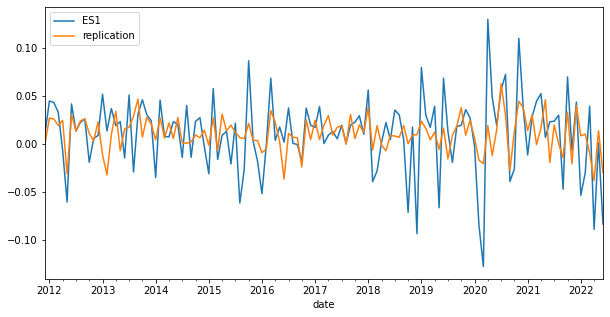

In [35]:
df_reg.plot(y=['ES1', 'replication'], figsize=(10,5))

In [36]:
r_star = df_reg['replication']

### Q3.1

In [37]:
reg_beta.tail(5)

,const,BP1
date,,
2022-02-28,0.01366,1.17889
2022-03-31,0.01443,1.14417
2022-04-30,0.01227,1.24756
2022-05-31,0.01301,1.18659
2022-06-30,0.01019,1.25176


### Q3.2

In [39]:
df_reg['replication'].tail(5)

date
2022-02-28    0.01015
2022-03-31   -0.00979
2022-04-30   -0.03827
2022-05-31    0.01357
2022-06-30   -0.03013
Name: replication, dtype: float64

### Q3.3

In [49]:
mean_vol_sharpe(df_reg[['ES1', 'replication']], ann=12)

,mean,volatility,sharpe_ratio
ES1,0.12422,0.13812,0.89931
replication,0.12633,0.06255,2.01983


### Q3.4

In [47]:
print("The correlation between ES1 and replication is:")
print(round(df_reg['ES1'].corr(df_reg['replication']),4)*100, '%')

The correlation between ES1 and replication is:
52.1 %


# Question 4

In [54]:
def risk_stats(data, q=0.05):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR (negated)'] = -df.quantile(q)
    report.loc['Expected Shortfall (negated)'] = -df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None
    report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days
    return round(report,4)

In [50]:
df_50 = df[['ES1','GC1']]
df_50.head(2)

,ES1,GC1
date,,
2009-01-31,-0.08611,0.04863
2009-02-28,-0.10729,0.01519


In [51]:
#portfolio with equal weights

df_50['portfolio'] = df_50.mean(axis=1)
df_50.head(5)

,ES1,GC1,portfolio
date,,,
2009-01-31,-0.08611,0.04863,-0.01874
2009-02-28,-0.10729,0.01519,-0.04605
2009-03-31,0.08721,-0.02111,0.03305
2009-04-30,0.09468,-0.03654,0.02907
2009-05-31,0.05517,0.09830,0.07674


### Q4.1

In [56]:
risk_stats(df_50)[4:]

,ES1,GC1,portfolio
Max Drawdown,-0.20317,-0.4296,-0.12098
MDD Start,2019-12-31,2011-08-31,2022-03-31
MDD End,2020-03-31,2015-12-31,2022-06-30
Recovery Date,2020-07-31,None,None
Recovery period (days),213.0,NaN,NaN


In [58]:
mean_vol_sharpe(df_50, ann=12)
#Technically not Sharpe ratio, but the ratio of the mean to the volatility

,mean,volatility,sharpe_ratio
ES1,0.12912,0.15107,0.85470
GC1,0.05401,0.16013,0.33727
portfolio,0.09156,0.11408,0.80262


### Q4.2

In [62]:
print("correlation b/w ES1 and GC1 is:")
print(round(df['ES1'].corr(df['GC1']),4)*100, '%')

correlation b/w ES1 and GC1 is:
7.42 %


- The 50/50 portfolio has a higher Mean to Vol Ratio than Gold but lower than ES1. But - the Volatility if the 50/50 portfolio is lower than each of the other two individual assets.
- The MDD is much lower for the 50/50 portfolio than the other two individual assets. Thus the 50/50 portfolio is the best portfolio in terms of MDD.

As per porfolio theory, the lower correlations between the assets would indeed indicate a a better portfolio which is diversifed. Economically speaking, the Gold is a hedge against inflation and ES1 is a hedge against deflation. Thus the 50/50 portfolio is a hedge against both inflation and deflation and thus is a better portfolio than the other two individual assets.

### Q4.3

In [63]:
mean_vol_sharpe(df_50, ann=12)

,mean,volatility,sharpe_ratio
ES1,0.12912,0.15107,0.85470
GC1,0.05401,0.16013,0.33727
portfolio,0.09156,0.11408,0.80262


In [95]:
# Calculate the 1-period, 1% CVaR of the 'portfolio' analytically.
# Calculate the CVaR in two different ways
# Use the full-sample volatility estimate.

VaR = df_50['portfolio'].quantile(0.01)
CVaR = df_50['portfolio'].loc[df_50['portfolio'] <= VaR].mean()
print('Analytical CVaR: ', round(CVaR,4))

Analytical CVaR:  -0.0804


In [101]:
#Use the latest value from the rolling 24-month volatility.

Vol_rolling = df_50['portfolio'].dropna().rolling(24).std()
Vol_latest = Vol_rolling.iloc[-1]
z_score = norm.ppf(0.01)
VaR_estimate = z_score * Vol_latest

CVaR = df_50['portfolio'].loc[df_50['portfolio'] <= VaR_estimate].mean()
print('CVaR estimate: ', round(CVaR,4))

CVaR estimate:  -0.0926


### Q4.4

In [102]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [103]:
df50_log = np.log(1+df_50)
df50_log.head(4)

,ES1,GC1,portfolio
date,,,
2009-01-31,-0.09004,0.04748,-0.01892
2009-02-28,-0.11350,0.01507,-0.04715
2009-03-31,0.08361,-0.02134,0.03251
2009-04-30,0.09046,-0.03723,0.02865


In [104]:
#probability that over next 10 year ES1 underfperform the portfolio

df50_log['diff'] = df50_log['ES1'] - df50_log['portfolio']
mu_tilde = df50_log['diff'].mean()*12
sig_tilde = df50_log['diff'].std()*np.sqrt(12)

prob([10] , mu_tilde, sig_tilde)

,Probability
h,
10,0.16837


In [107]:
print("The probability that ES1 underperforms the portfolio over the next 10 years is:")
print(round(prob([10] , mu_tilde, sig_tilde).iloc[0,0]*100,4), '%')

The probability that ES1 underperforms the portfolio over the next 10 years is:
16.8365 %
